In [97]:
%matplotlib inline
%matplotlib nbagg
%matplotlib notebook 

import warnings
warnings.filterwarnings('default', category=DeprecationWarning, module='.*/mypackage/.*')
from IPython.display import display
#mpld3.enable_notebook()
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

from __future__ import division
import sympy as sym
from sympy import *
x, y, z = symbols("x y z")
k, m, n = symbols("k m n", integer=True)
f, g, h = map(Function, 'fgh')
import sympy.abc as a
e = E

from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np

# Real Time Widgets in HTML Exports

In [110]:
ht = """
	<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/3.1.0/jquery.min.js"></script>
	<script>JSSOURCE</script>
	<script src="https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.17/d3.js"></script>
	<script src="https://cdn.rawgit.com/novus/nvd3/master/build/nv.d3.min.js"></script>
	<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/nvd3/1.8.4/nv.d3.min.css">
	<link href='http://fonts.googleapis.com/css?family=Quantico' rel='stylesheet' type='text/css'>
	<script src="https://cdnjs.cloudflare.com/ajax/libs/jstat/1.5.3/jstat.min.js"></script>
	<div class="container-fluid">
	<div id="chartPID" class="col-md-9">
	<svg></svg>
	</div>
	<div id="slidersPID" class="col-md-3">
  	</div>
	</div>
	<script>\

    var historicalBarChartPID = [
        
    { 
      "key" : "" , 
      "bar": true,
      "color": "#ccf",
      "values" : []}
    ];
    var chartPID;
    function sliderToHTML(name,min,max,step){
      var htmlZ = '<div class="slider"><label>'+name+'</label><input type = "range" min="'+min+'" max="'+max+'" step="'+step+'" onchange="'+name+'valuePID.value=value;updatePID();"/><output class="slider" id="'+name+'valuePID">'+(min+max)/2+'</output></div>';
      return htmlZ;
    }

    function addSlider(name,min,max,step){
      var html = sliderToHTML(name,min,max,step);
      var sLoc = $('#slidersPID');
      sLoc.html(sLoc.html()+html);
    }

    function addAllSliders(){
      sls = tmpPID.inputs();
      for(i = 0; i < sls.length; i++){
        inp = sls[i];
        addSlider(inp[0],inp[1],inp[2],inp[3]);
      }
    }
    addAllSliders();
    function updatePID() {
    	var values = $.map($("#slidersPID output"), function(x){return parseFloat(x.value);});
    	historicalBarChartPID[0].values = tmpPID.data.apply(this,values);
    	chart2 = d3.select('#chartPID svg');
	    chart2.datum(historicalBarChartPID).transition().duration(500).call(chartPID);
    	nv.utils.windowResize(chartPID.update);
	};

    nv.addGraph(function() {
        chartPID = nv.models.discreteBarChart()
            .x(function(d) { return d[0] })
            .y(function(d) { return d[1] })
            .staggerLabels(true)
            //.staggerLabels(historicalBarChart[0].values.length > 8)
            .duration(250)
            ;
        d3.select('#chartPID svg')
            .datum(historicalBarChartPID)
            .call(chartPID);
        nv.utils.windowResize(chartPID.update);
        updatePID();
        return chartPID;
    });
</script>

"""

In [123]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
from IPython.core.display import display, HTML
from subprocess import call
import time
import os

pythonFile = """
math = Math
def inputs():
    return [%s]

%s
"""
pid = 0

@register_cell_magic
def cmagic(line, cell):
    global pid
    pid += 1
    pF = pythonFile%(line,cell)
    fileName = 'tmp%d'%pid
    f = open(fileName+'.py','w')
    f.write(pF)
    f.close()
    call(["transcrypt", fileName+".py",'--nomin'])
    js = open("__javascript__/"+fileName+".js").read()
    js = js.replace('enumerable: true', 'enumerable: true, configurable:true')
    os.remove(fileName+'.py')
    os.remove("__javascript__/"+fileName+".js")
    return HTML(ht.replace("JSSOURCE",js).replace("PID",str(pid)))



In [126]:
%%cmagic ['x',0,10,1]
def data(x):
    return [(i,math.pow(i,2)) for i in range(x)]

In [127]:
%%cmagic ['n',0,100,5], ['p',0,1,.1]
#BINOMIAL PROBABILITIES
def prob(n,p,x):
	q = 1-p
	nx = n - x
	return jStat.combination(n,x)*Math.pow(p,x)*Math.pow(q,nx)

def data(n,p):
	return [[i,prob(n,p,i)] for i in range(n+1)]


In [128]:
%%cmagic ['mu',0,10,1]
#POISSON PROBABILITIES

def factorial(x):
    i = 1
    for _ in range(1,x+1):
        i *= _
    return i

def prob(mu,x):
	return math.pow(math.E,-1*mu)*math.pow(mu,x)/factorial(x)

def data(mu):
	return [[i,prob(mu,i)] for i in range(4*mu)]


In [130]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed


In [100]:
def plots(expr,val,discrete=False):
    variable,start,end = val
    if discrete:
        x = np.linspace(start,end,end-start+1)
    else:
        x = np.linspace(start,end,100)
    y = [expr.subs(variable,i).evalf() for i in x]
    if not discrete:
        plt.plot(x,y)
    else:
        plt.bar(x-.5,y)
    plt.ylim(ymin=0)

In [101]:
import mpmath
class BinomialDistribution:
    def __init__(self,n,p):
        self.x = symbols("x")
        self.formula = binomial(n,x)*p**x*(1-p)**(n-x)
        self.n = n
        self.p = p
    def plot(self):
        plots(self.formula,(self.x,0,self.n),True)

    def vary(startn=10,startp=.5):
        import time
        a = time.time()
        def plott(n,p):
            nonlocal a
            if time.time()-a < .1:
                return
            BinomialDistribution(n,p).plot()
            a = time.time()
        interact(plott,n=widgets.IntSlider(min=1,max=200,value=startn),p=widgets.FloatSlider(value=startp,min=0,max=1,step=.01))


In [103]:
%matplotlib inline
BinomialDistribution.vary()

<IPython.core.display.Javascript object>


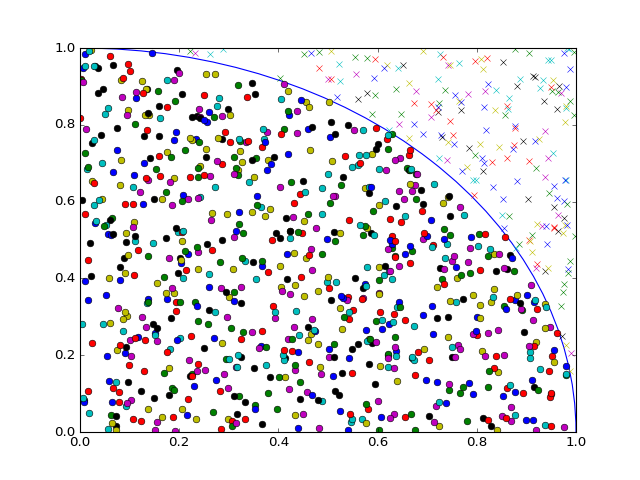

Pi estimate is  3.13776


In [94]:
%matplotlib notebook
circle1=plt.Circle((0,0),1,color='w',ec='b')
plt.gcf().gca().add_artist(circle1)
import random
import time
plt.xlim(0,1)
plt.ylim(0,1)
v = 0
n = 100000
for _ in range(n):
    x = random.random()
    y = random.random()
    if x**2 + y**2 > 1:
        if _%(n//1000) == True:
            plt.plot([x],[y],marker='x')
    else:
        if _%(n//1000) == True:
            plt.plot([x],[y],marker='o')
        v += 1
print("Pi estimate is ", (v*4/n))